In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import wfdb
from scipy.signal import butter, sosfilt, sosfreqz, ShortTimeFFT, get_window
import matplotlib.colors as mcolors
import os


2024-12-17 14:56:21.115562: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 14:56:21.135548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734476181.157415 1477517 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734476181.163826 1477517 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:56:21.187463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
path = '~/Desktop/ptb-xl/'
dataset = pd.read_json(path+'updated_ptbxl_database.json')
dataset = dataset[['filename_lr', 'filename_hr', 'NORM', 'ABNORM']]

In [5]:
leads = ['I', 'II', 'V2']
classes = ['NORM', 'ABNORM']
batch_size = 32

# Data Loading Pipeline
In this section, we define a number of functions that will be used to efficiently load, transform and format the batches of signals. Using the rational discussed in this [paper](https://www.sciencedirect.com/science/article/pii/S174680942400199X#sec4), all but three leads from each signal sample will be dropped, keeping leads I, II and V2. This will save a computational cost and make the training more efficient. A band pass filter will then be applied to each signal to trim out baseline wander noise and high frequency noise above 45hz. A spectrogram operation will be applied to each lead, then the leads will be stacked on top of each other to create a (3, 1000, 45) matrix. This will be passed into the network.

1. Load only 3 leads of the signal
2. Apply bandpass filter
3. Apply spectrogram (STFT)
4. Combine signals into a matrix [signals, timesteps, frequency steps] (3, 1000, n) n is undecided for now

### 1: Loading the signals

In [6]:
def load_batch(df, path='ptb-xl/', sampling_rate=100):
    df_files = df.filename_lr if sampling_rate == 100 else df.filename_hr
    data = [
            wfdb.rdsamp(os.path.join(path, f), channel_names=leads, return_res=32)[0].T
            for f in df_files
        ]
    
    labels = df[classes].to_numpy()

    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    return data_tensor, labels_tensor

In [8]:
data, labels = load_batch(dataset[:32], path='/home/lrbutler/Desktop/ptb-xl/', sampling_rate=100)

I0000 00:00:1734476331.814547 1477517 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79091 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:03:00.0, compute capability: 8.0


### 2: Designing the bandpass filter
I have some background in signal processing due to my undergraduate degree in computer engineering. I had ChatGPT generate me some code to help design the filter.

/tmp/ipykernel_1477517/1640021051.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w, 20 * np.log10(abs(h)))


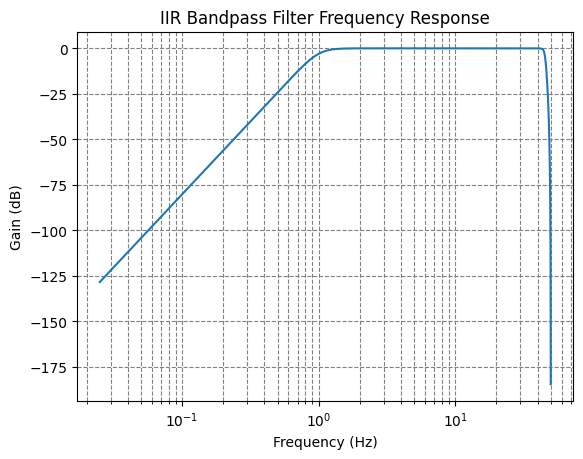

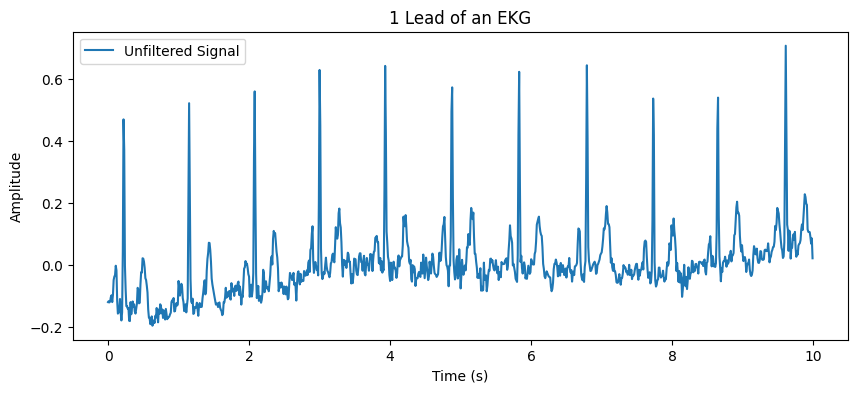

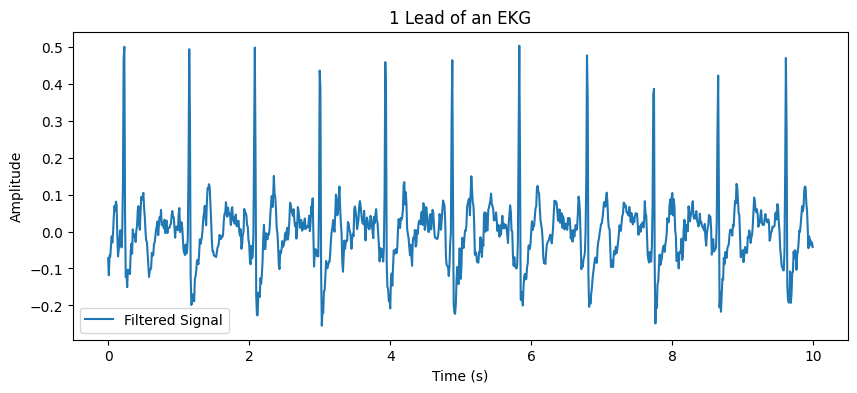

In [10]:
# Band pass filter
lowcut = 1.0          # Lower cutoff frequency (Hz)
highcut = 45.0        # Upper cutoff frequency (Hz)
fs = 100.0            # Sampling frequency (Hz)
order = 4             # Filter order (higher = steeper rolloff)

# Define the IIR bandpass filter
def design_iir_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')  # Second-order sections
    return sos

# Design the filter
sos = design_iir_bandpass(lowcut, highcut, fs, order)

# Visualize frequency response
w, h = sosfreqz(sos, worN=2000, fs=fs)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('IIR Bandpass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(which='both', linestyle='--', color='gray')
plt.show()

# Apply the filter to a signal (example)
def apply_filter(signal, sos):
    return sosfilt(sos, signal)

seconds = 10.0
t = np.linspace(0, seconds, int(fs * seconds), endpoint=False)  # 1 second of data
data, labels = load_batch(dataset.iloc[:1], path='/home/lrbutler/Desktop/ptb-xl/')
data = data[0][0][:int(fs * seconds)]
filtered_signal = apply_filter(data, sos)

# Plot original vs. filtered signal
# plt.plot(t, data, label="Original Signal")
plt.figure(figsize=(10,4))
plt.plot(t, data, label="Unfiltered Signal")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('1 Lead of an EKG')
plt.autoscale
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, filtered_signal, label="Filtered Signal")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('1 Lead of an EKG')
plt.autoscale
plt.legend()
plt.show()


### 3: Apply Spectrogram

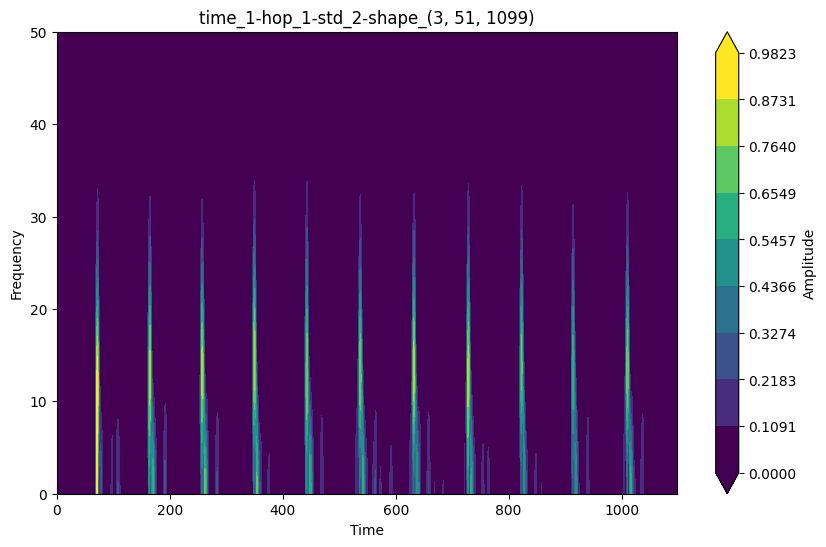

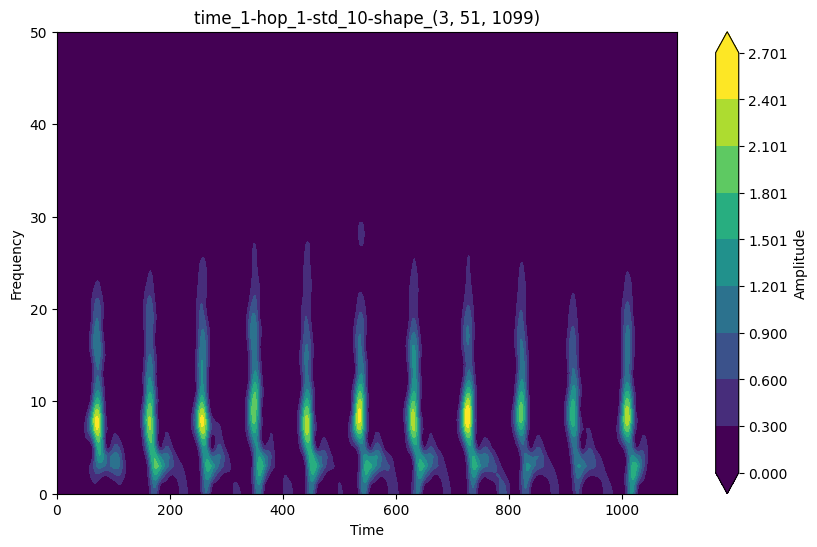

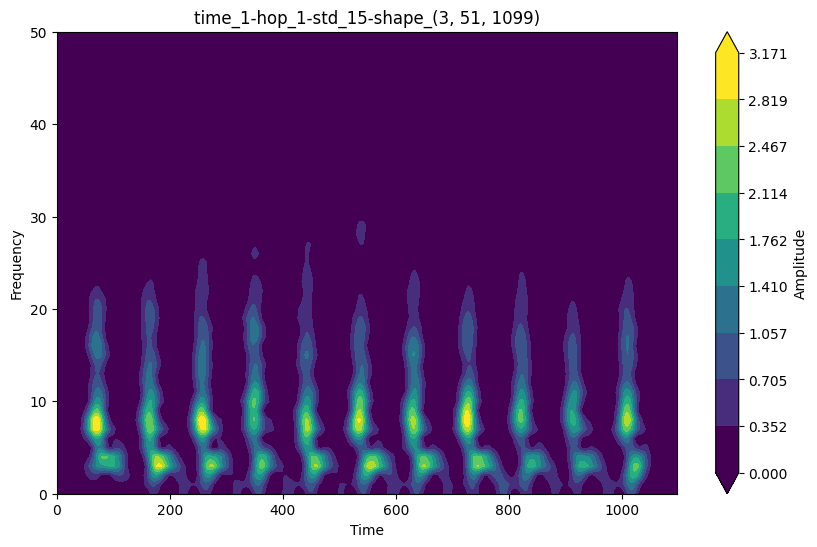

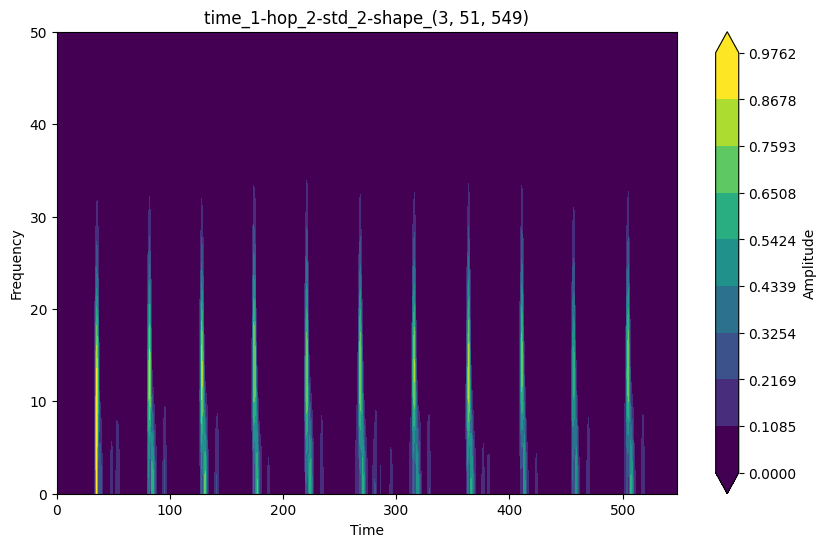

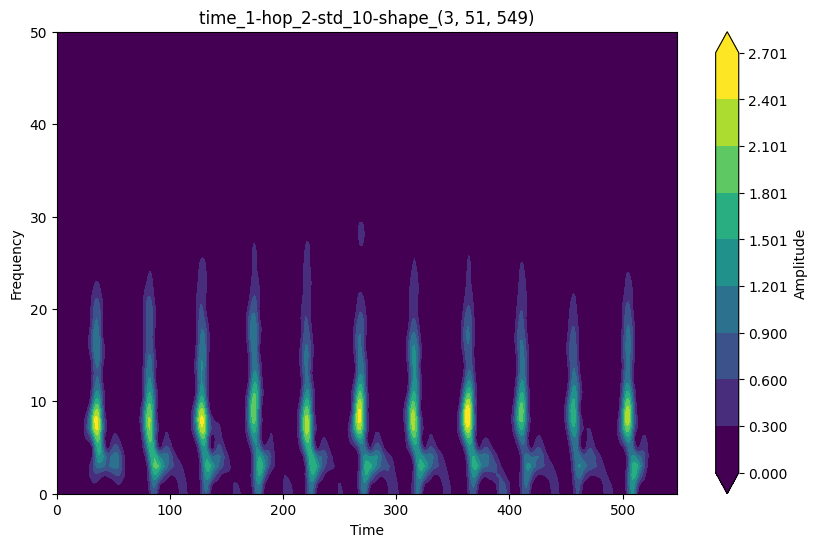

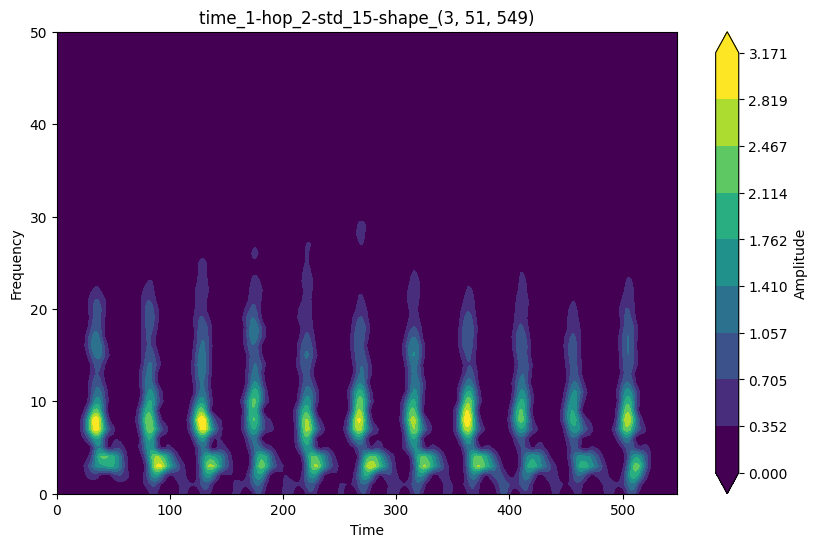

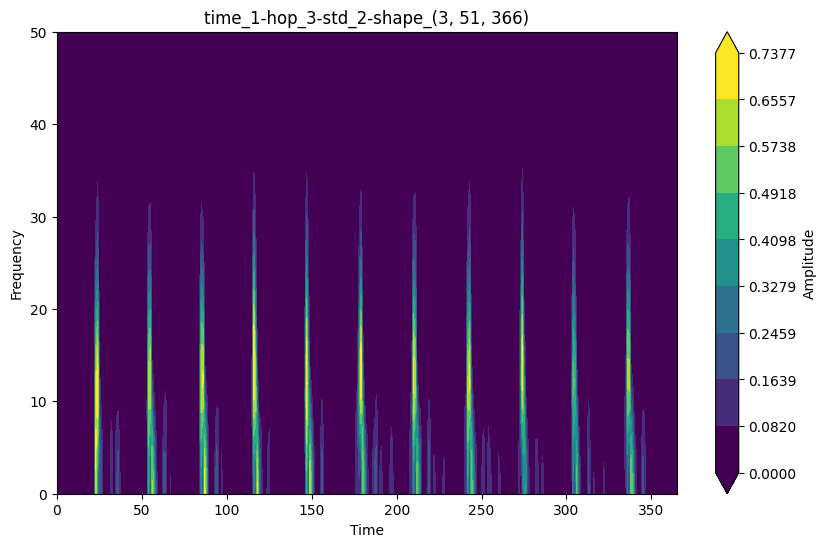

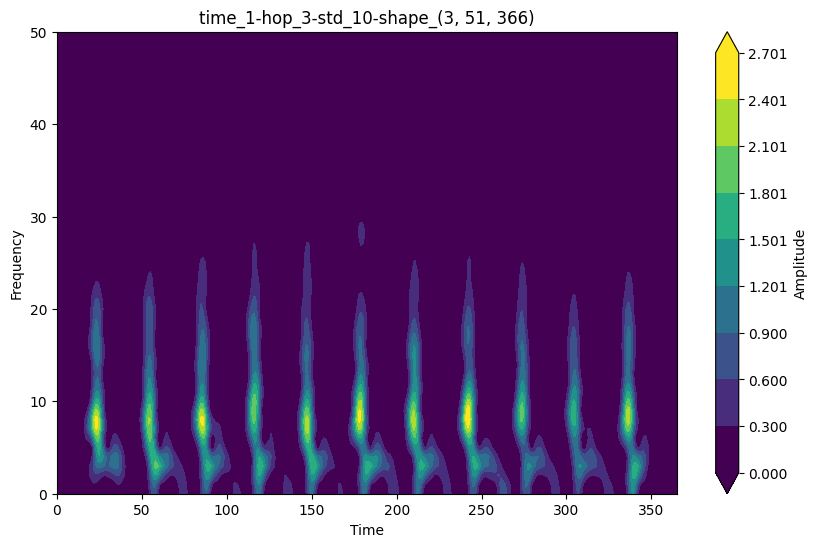

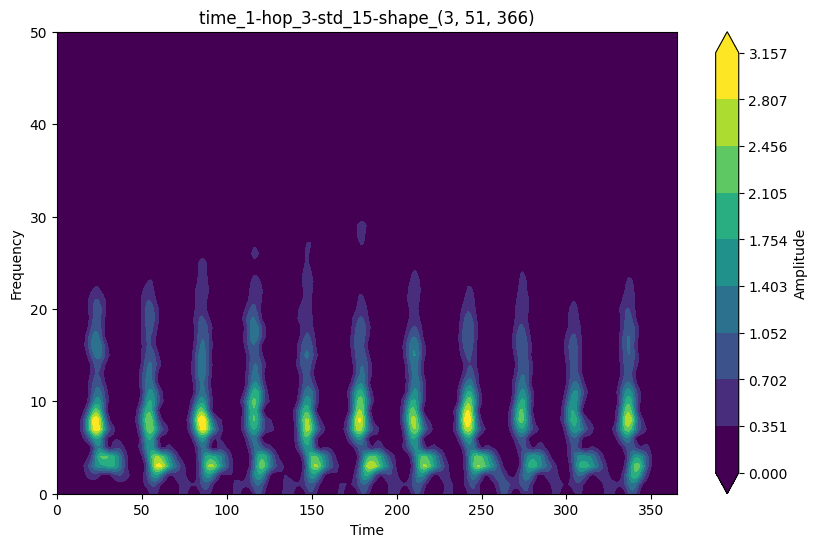

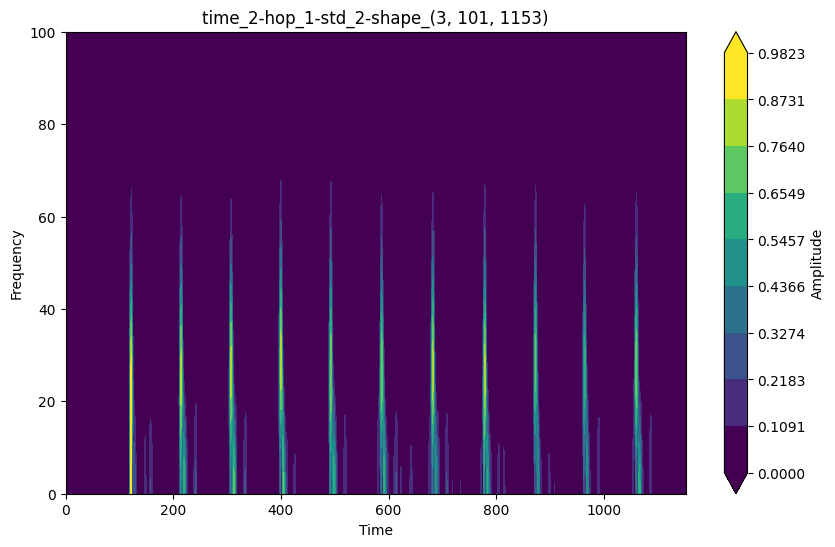

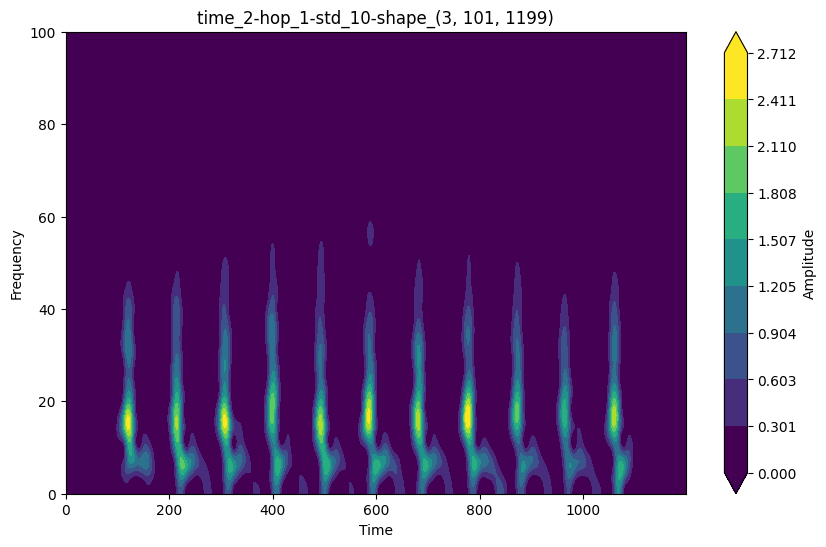

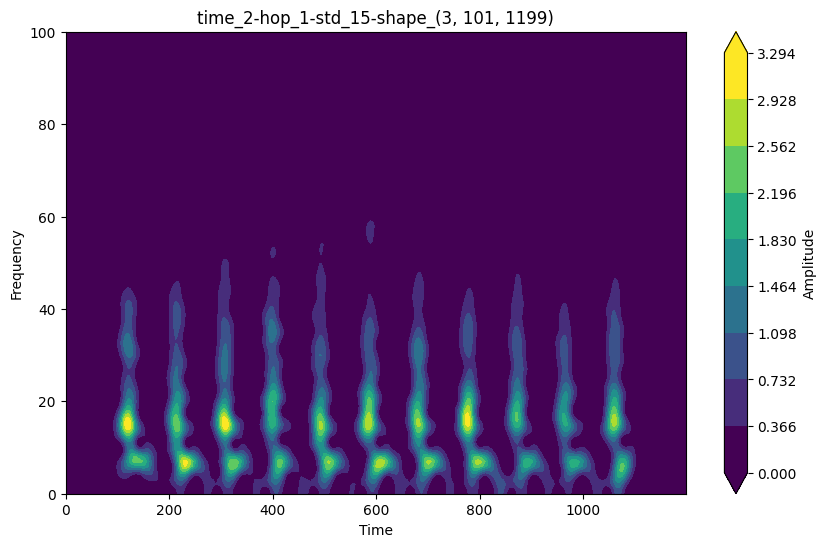

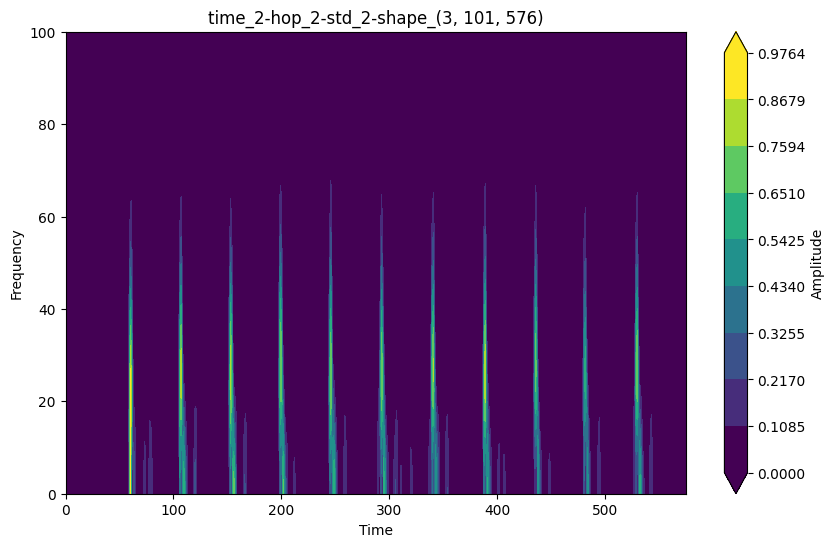

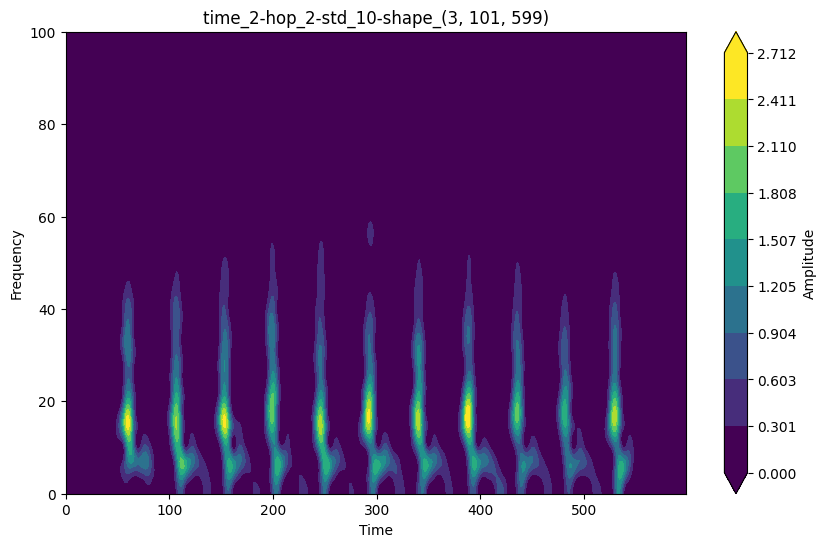

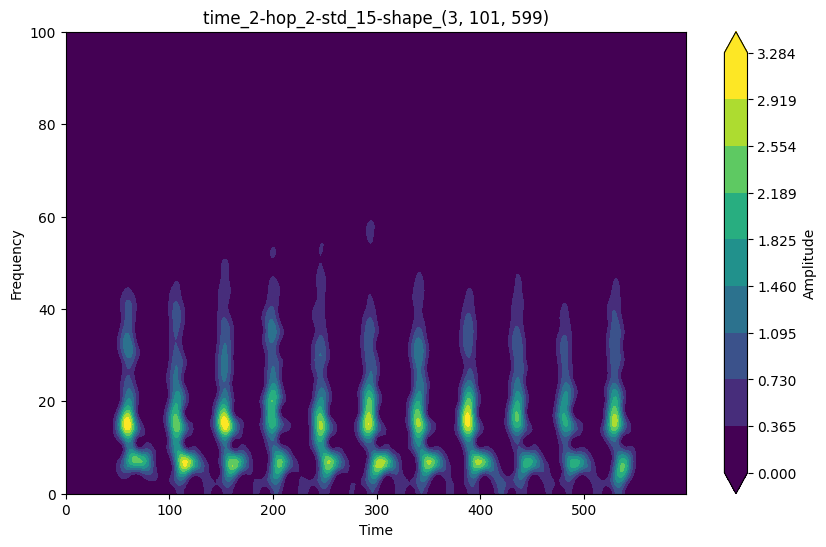

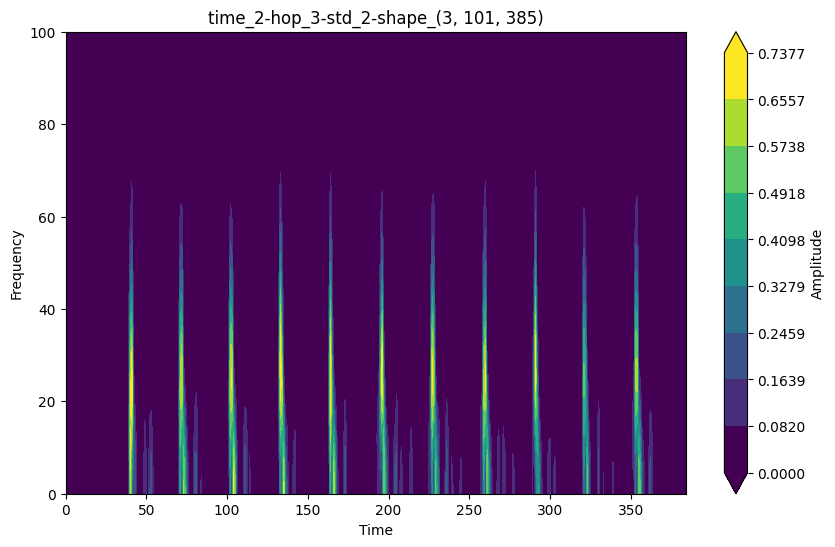

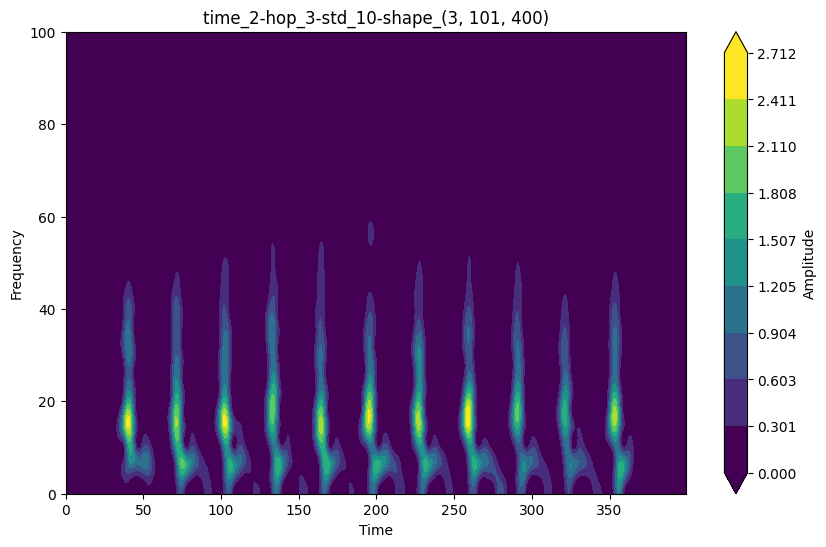

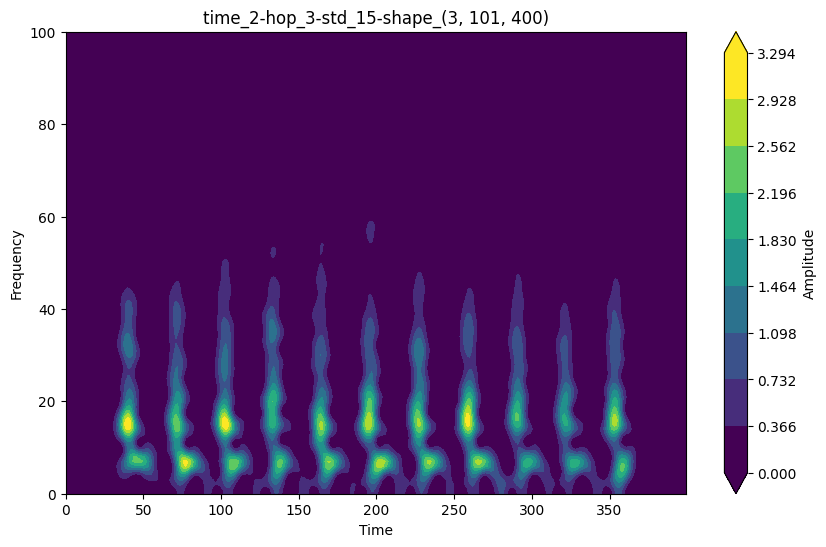

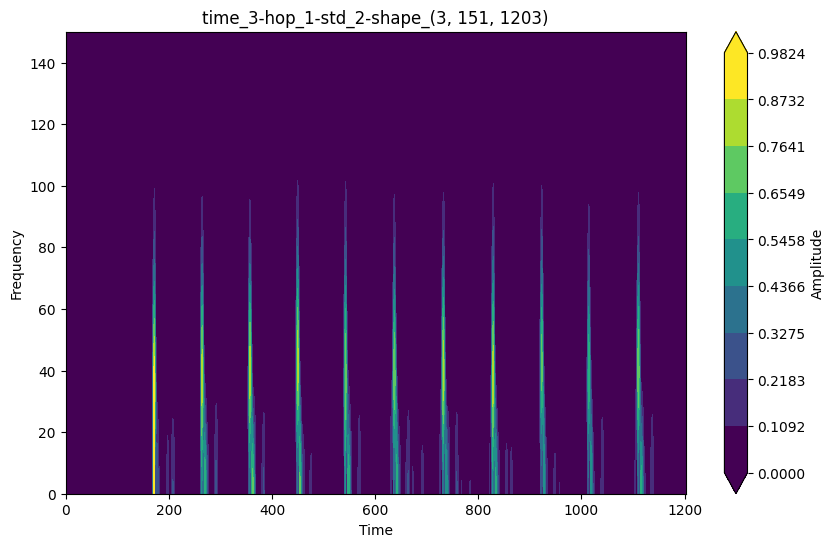

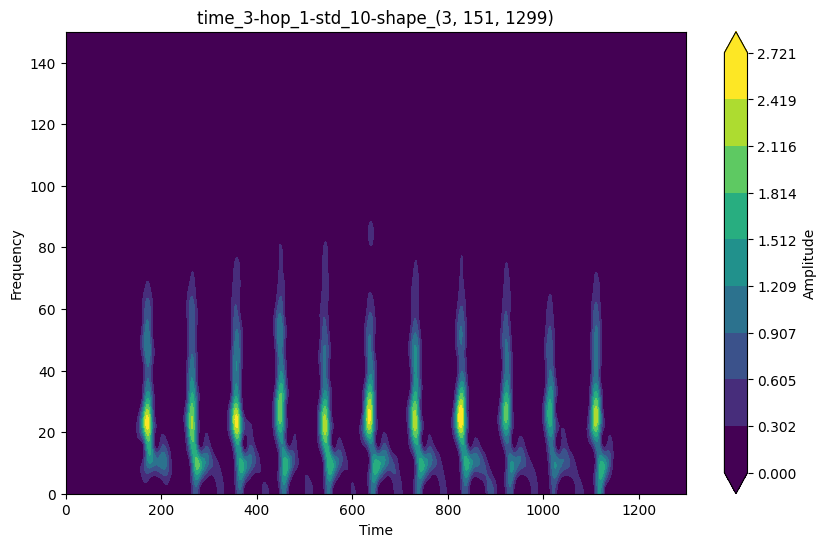

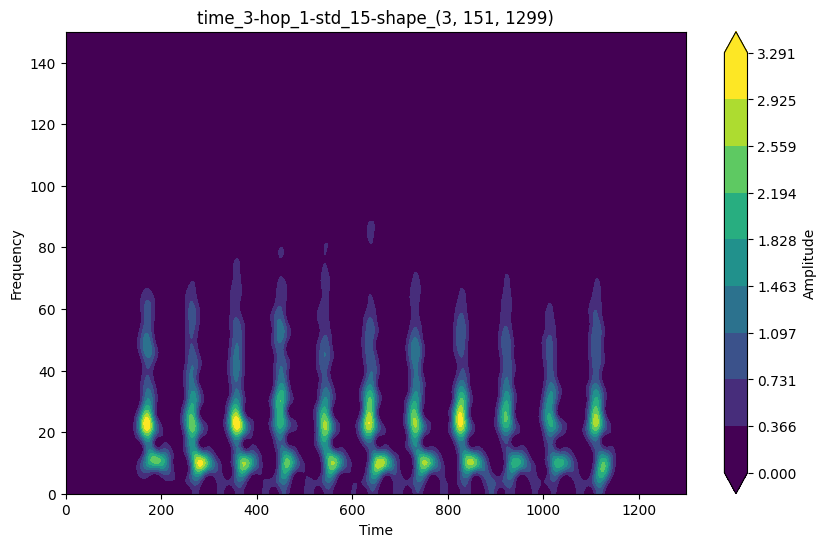

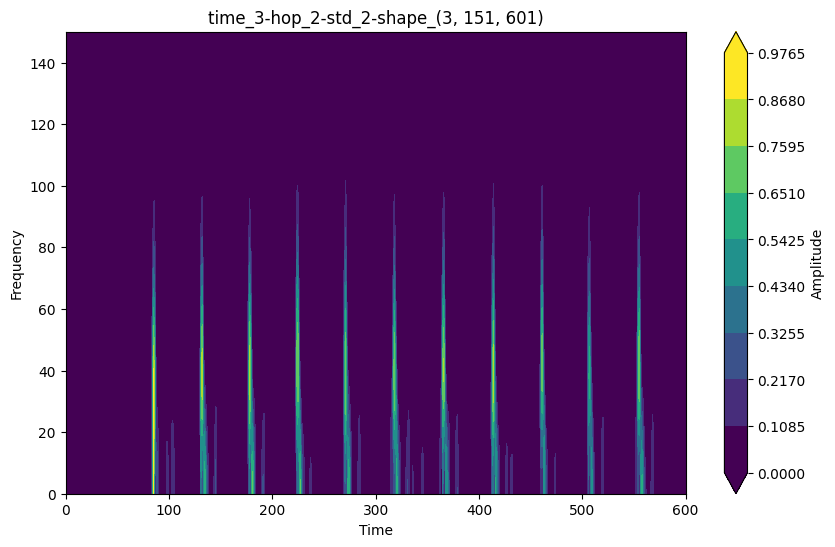

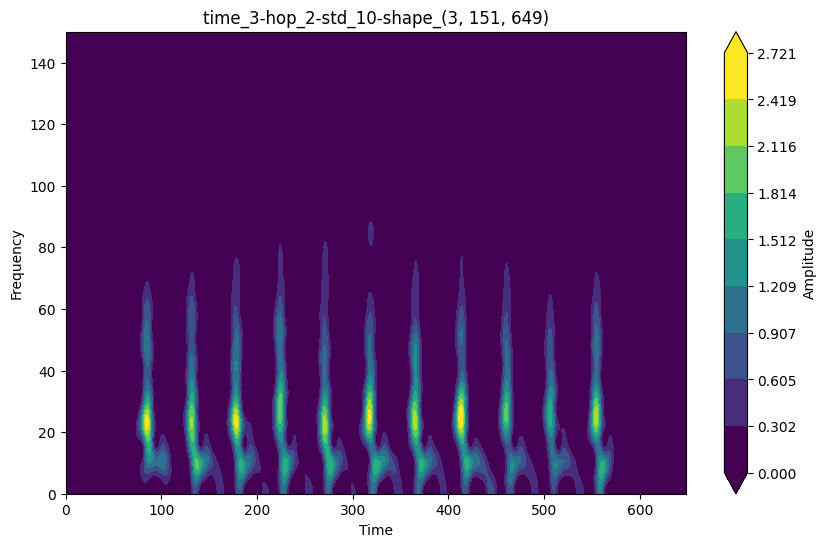

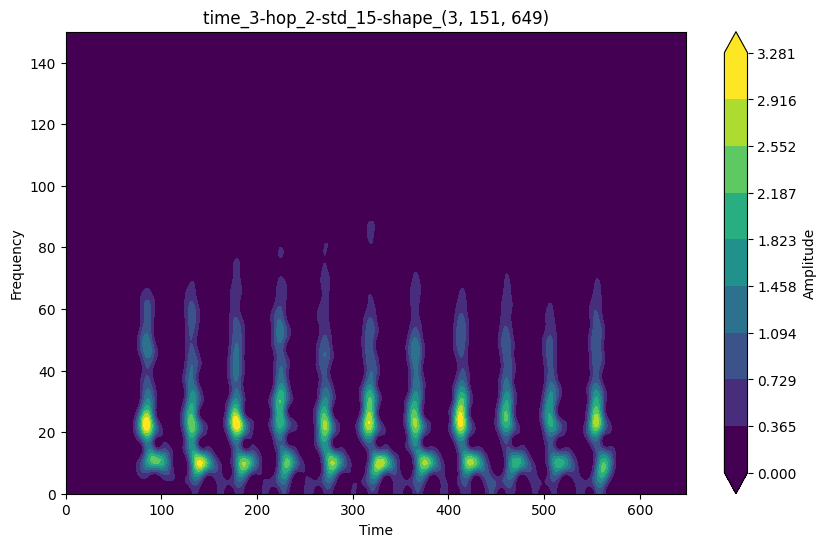

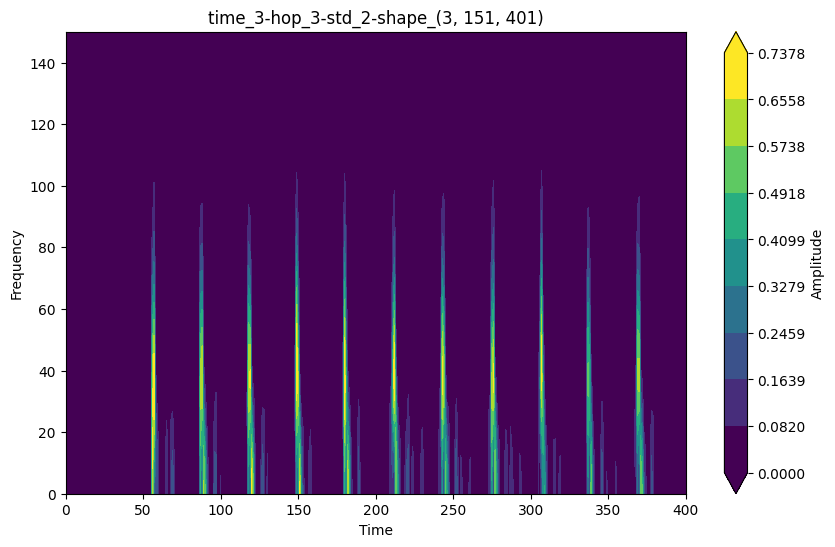

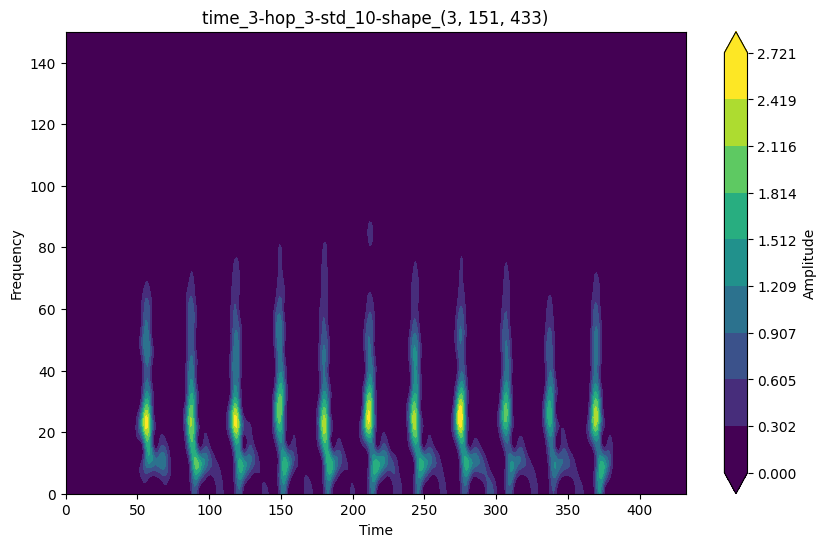

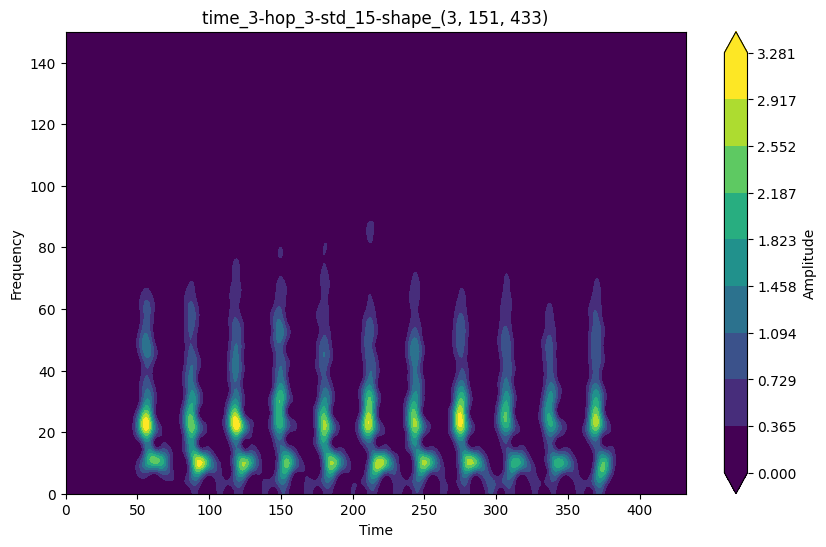

In [13]:
import itertools

time_length = [1, 2, 3]
hop = [1, 2, 3]
gaussian_std = [2, 10, 15]

combs = itertools.product(time_length, hop, gaussian_std)

for t, h, std in combs:

    # Standard deviation of 2
    nperseg = fs * t  # Length of each segment, 2 seconds in this case
    hop = h  # Overlap between segments, 50% hop in this case

    w = get_window(('gaussian', std), nperseg)
    sft = ShortTimeFFT(w, hop, fs=fs) #mfft=150)

    def apply_spectrogram(signal, sft=sft):
        spectrogram = sft.spectrogram(signal)
        return spectrogram

    def preprocess_batch(df, sos, sft, sampling_rate=fs):
        # Load data and labels
        data, labels = load_batch(df, path='/home/lrbutler/Desktop/ptb-xl/', sampling_rate=sampling_rate)
        filtered_data = sosfilt(sos, data, axis=-1)
        spectrogram_data = np.apply_along_axis(func1d=apply_spectrogram, axis=2, arr=filtered_data, sft=sft)
        
        return spectrogram_data, labels

    data, labels = preprocess_batch(dataset[:1], sos, sft)
    shape = data.shape[1:]

    title = f"time_{t}-hop_{h}-std_{std}-shape_{shape}"

    # Define a discrete colormap
    levels = np.linspace(data[0][0].min(), data[0][0].max(), 10)  # Adjust number of levels
    cmap = mcolors.ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(levels) - 1)))

    # Plot with the discrete colormap
    plt.figure(figsize=(10, 6))
    plt.contourf(data[0][0], levels=levels, cmap=cmap, extend='both')
    plt.colorbar(label='Amplitude', ticks=levels)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()